In [ ]:
# plan

# - caclulate monthly Q for different land covers 
# - calculate how on average change in lang cover affect the change in runoff -> transport capacity -> TL case 



# plan
# 1 - calculate the monthly water yeild 
# 2 - plot average + spread per month 


In [3]:
import pandas as pd 
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import os
import seaborn as sns


import functions






In [ ]:
# hydrology does not depend on the sediment input, so in principle hydro.out is the same all the time and only differs per land cover 
# -> its ok to take it from the (chosen) sediment input
# NB: SO FAR (as of 9/12/2024) the landcover 5 has only been run on the TL scenario and is stored in a different place 
# to compare the land covers 
testfile = pd.read_csv('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/langtang_climate_cut/12a/Hydro.out')
testfile


# discharge in m3, but what about other water components?

In [ ]:
def calculate_monthly_water_volume_all(hydro, column, area=4830.0):
    """
    Calculate the sum of water or sediment volume per month for a specific column, 
    and return the mean volumes across years.
    
    Parameters:
    hydro (pd.DataFrame): Input DataFrame with columns `D` (date) and the specified numeric column.
    column (str): The name of the column to calculate the volume for.
    area (float): Area in square meters used to scale the volumes. Default is 4830.0.
    
    Returns:
    pd.DataFrame: DataFrame with the calculated monthly volumes.
    """
    # Ensure `D` column is in datetime format
    hydro['D'] = pd.to_datetime(hydro['D'])
    
    # Check if the specified column exists
    if column not in hydro.columns:
        raise ValueError(f"The specified column '{column}' does not exist in the DataFrame.")
    
    # Scale the specified column by the area
    hydro_scaled = hydro.copy()
    hydro_scaled[column] = hydro_scaled[column] * area
    
    # Set 'D' as the index
    hydro_scaled = hydro_scaled.set_index('D')
    
    # Resample to monthly data and calculate the sum for each month for the specified column
    hydro_month = hydro_scaled[column].resample('M').sum().reset_index()
    
    # Extract year and month for grouping or further analysis
    hydro_month['year'] = hydro_month['D'].dt.year
    hydro_month['month'] = hydro_month['D'].dt.month
    
    return hydro_month


In [ ]:
%%time

column = 'PET'  # Set the target column
location = 'langtang'

folder_langtang = '/12a/'
folder_mustang = '/13a/'

folder_location = folder_langtang

landcover1_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut'
landcover2_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut'
landcover3_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut'
landcover4_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut'
landcover5_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/{location}_climate_cut'


output_path = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro'

# Define the list of folder paths
folder_paths = [f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut',
                f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/2landcover_40percent/{location}_climate_cut', 
                f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/3landcover_40percent/{location}_climate_cut', 
                f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/4landcover_40percent/{location}_climate_cut', 
                f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/{location}_climate_cut']



# Load elevation data and define the output path
elevation = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/downscaling_simple/coordinates_and_elevation_with_labels_{location}.csv')[['cellnr2', 'band_data']]
elevation = elevation.transpose()
elevation_list = elevation.loc['cellnr2'].tolist()  # Adjust if you need a specific list format


In [ ]:
%%time

# Iterate over folder paths
for folder_path in folder_paths:
    print(f"Processing folder: {folder_path}")

    output_folder = output_path

    # Extract "1landcover" from the folder path
    landcover_part = os.path.basename(os.path.dirname(folder_path))
    landcover_base = landcover_part.split('_')[0]  # This gives "1landcover"

    # Load timestep DataFrame (assuming Hydro.out exists in the `/13a/` subfolder for all folders)
    hydro_path = os.path.join(folder_path, '12a', 'Hydro.out')
    print(f"Checking Hydro.out path: {hydro_path}")

    if not os.path.isfile(hydro_path):
        print(f"Hydro.out not found in {hydro_path}")
        continue  # Skip this folder_path if the main Hydro.out is missing

    # Load the Hydro.out file for timestep calculation
    try:
        dfts = pd.read_csv(hydro_path)
        df = calculate_monthly_water_volume_all(dfts, column, area=4830.0)
        df = df[['month', 'year']]
    except Exception as e:
        print(f"Error loading timestep file: {e}")
        continue

    # Initialize the result DataFrame for this folder_path
    result_df = pd.DataFrame()

    # Iterate over subfolders in the folder path
    for folder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, folder_name)
        
        # Skip files and hidden folders
        if not os.path.isdir(subfolder_path) or folder_name.startswith('.'):
            continue

        file_path = os.path.join(subfolder_path, 'Hydro.out')
        print(f"Checking subfolder Hydro.out: {file_path}")

        # Ensure the Hydro.out file exists in the subfolder
        if os.path.isfile(file_path):
            try:
                hydro = pd.read_csv(file_path)
                output_df = calculate_monthly_water_volume_all(hydro, column)

                # Extract and rename the target column
                name_column = output_df[column]
                column_name = f'{column}_{folder_name}'
                result_df[column_name] = name_column
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
                continue

    # Ensure result_df has data before proceeding
    if result_df.empty:
        print(f"No valid data found in subfolders of {folder_path}")
        continue

    # Rename columns for clarity and filter by elevation list
    result_df.columns = [col[-3:] for col in result_df.columns]  # Adjust column names if necessary
    result_df = result_df[elevation_list]

    # Check for consistency with the elevation list
    if elevation_list == result_df.columns.tolist():
        print("Default land cover. Monthly data: same")

        # Rename columns, merge with timestep, and add folder info
        result_df.columns = elevation.loc['band_data']
        result_df = pd.concat([df, result_df], axis=1)
        result_df['folder'] = os.path.basename(folder_path)

        print(result_df)

        # Define the output file name and save the DataFrame to a CSV file
        output_filename = f'{location}_monthly_sum_elevation_{column}_{landcover_base}.csv'
        print('output filename:', output_filename)
        result_df.to_csv(os.path.join(output_folder, output_filename), index=False)

        print(f"Saved {output_filename}")
    else:
        print(f"The data does not match the elevation list for {folder_path}!")


In [70]:
testfile = pd.read_csv('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/langtang_climate_cut/12a/Hydro.out')
testfile

,D,Q,Qs,Qss,Vw,snow,snowacc,PET,AET,Pr,Ta,glacier_melt
0,1989-09-01 00:00:00,0.000000,0.0,0.000000,0.000000,0.0,0.0,3.304293,0.000000,0.009842,3.654126,0.0
1,1989-09-01 01:00:00,0.000367,0.0,0.000367,0.020718,0.0,0.0,0.000000,0.000000,0.021085,4.217486,0.0
2,1989-09-01 02:00:00,0.000590,0.0,0.000590,0.044152,0.0,0.0,0.089677,0.008311,0.032336,4.998886,0.0
3,1989-09-01 03:00:00,0.000005,0.0,0.000005,0.050061,0.0,0.0,0.351324,0.034852,0.040766,6.196086,0.0
4,1989-09-01 04:00:00,0.000008,0.0,0.000008,0.053671,0.0,0.0,0.734589,0.025902,0.029519,6.960796,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
289987,2022-09-30 19:00:00,0.005273,0.0,0.005273,1.233932,0.0,0.0,3.797599,0.003690,0.003714,1.346846,0.0
289988,2022-09-30 20:00:00,0.005251,0.0,0.005251,1.228690,0.0,0.0,3.777321,0.001229,0.001237,1.188496,0.0
289989,2022-09-30 21:00:00,0.005228,0.0,0.005228,1.223461,0.0,0.0,3.745847,0.000000,0.000000,0.942856,0.0
289990,2022-09-30 22:00:00,0.005206,0.0,0.005206,1.218263,0.0,0.0,3.712176,0.001229,0.001237,0.680256,0.0


In [ ]:
# testfile.snow.plot()

testfile.Pr.plot()
testfile.snowacc.plot()

testfile['snowmelt'] = testfile['snowacc'].where(testfile['snowacc'] < 0).fillna(0)
testfile['snowacc2'] = testfile['snowacc'].where(testfile['snowacc'] > 0).fillna(0)

In [ ]:
testfile.snowacc2.plot()
testfile.snowmelt.plot()

# calculate the monthly values in mm 

In [4]:
def water_balance_components_in_mm(hydro, column, area=4830.0):
    """
    Calculate the sum of water or sediment volume per month for a specific column, 
    and return the mean volumes across years.
    
    Parameters:
    hydro (pd.DataFrame): Input DataFrame with columns `D` (date) and the specified numeric column.
    column (str): The name of the column to calculate the volume for.
    area (float): Area in square meters used to scale the volumes. Default is 4830.0.
    
    Returns:
    pd.DataFrame: DataFrame with the calculated monthly volumes.
    """
    # Ensure `D` column is in datetime format
    hydro['D'] = pd.to_datetime(hydro['D'])

    if column == 'snowmelt':
        hydro['snowmelt'] = hydro['snowacc'].where(hydro['snowacc'] < 0).fillna(0)
    if column == 'snowacc2':
        hydro['snowacc2'] = hydro['snowacc'].where(hydro['snowacc'] > 0).fillna(0)
    
    # Scale the specified column by the area
    hydro[column] = hydro[[column]]
    
    # Set 'D' as the index
    hydro = hydro.set_index('D')
    
    # Resample to monthly data and calculate the sum for each month for the specified column
    hydro_month = hydro[column].resample('M').sum().reset_index()
    
    # Extract year and month for grouping or further analysis
    hydro_month['year'] = hydro_month['D'].dt.year
    hydro_month['month'] = hydro_month['D'].dt.month
    
    return hydro_month


In [5]:
# test1 = water_balance_components_in_mm(testfile, 'PET')
# test1

In [6]:
# test1.PET.plot()

In [9]:
%%time

column = 'Pr'  # Set the target column
location = 'mustang'

folder_langtang = '/12a/'
folder_mustang = '/13a/'

folder_location = folder_langtang

landcover1_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut'
landcover2_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut'
landcover3_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut'
landcover4_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut'
landcover5_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/{location}_climate_cut'


output_path = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro'

# Define the list of folder paths
folder_paths = [f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut',
                f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/2landcover_40percent/{location}_climate_cut', 
                f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/3landcover_40percent/{location}_climate_cut', 
                f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/4landcover_40percent/{location}_climate_cut', 
                f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/{location}_climate_cut']



# Load elevation data and define the output path
elevation = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/downscaling_simple/coordinates_and_elevation_with_labels_{location}.csv')[['cellnr2', 'band_data']]
elevation = elevation.transpose()
elevation_list = elevation.loc['cellnr2'].tolist()  # Adjust if you need a specific list format


CPU times: user 10.5 ms, sys: 3.25 ms, total: 13.7 ms
Wall time: 11.9 ms


In [10]:
%%time

# Iterate over folder paths
for folder_path in folder_paths:
    print(f"Processing folder: {folder_path}")

    output_folder = output_path

    # Extract "1landcover" from the folder path
    landcover_part = os.path.basename(os.path.dirname(folder_path))
    landcover_base = landcover_part.split('_')[0]  # This gives "1landcover"

    # Load timestep DataFrame (assuming Hydro.out exists in the `/13a/` subfolder for all folders)
    hydro_path = os.path.join(folder_path, '13a', 'Hydro.out')
    print(f"Checking Hydro.out path: {hydro_path}")

    if not os.path.isfile(hydro_path):
        print(f"Hydro.out not found in {hydro_path}")
        continue  # Skip this folder_path if the main Hydro.out is missing

    # Load the Hydro.out file for timestep calculation
    try:
        dfts = pd.read_csv(hydro_path)
        df = water_balance_components_in_mm(dfts, column, area=4830.0)
        df = df[['month', 'year']]
    except Exception as e:
        print(f"Error loading timestep file: {e}")
        continue

    # Initialize the result DataFrame for this folder_path
    result_df = pd.DataFrame()

    # Iterate over subfolders in the folder path
    for folder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, folder_name)
        
        # Skip files and hidden folders
        if not os.path.isdir(subfolder_path) or folder_name.startswith('.'):
            continue

        file_path = os.path.join(subfolder_path, 'Hydro.out')
        # print(f"Checking subfolder Hydro.out: {file_path}")

        # Ensure the Hydro.out file exists in the subfolder
        if os.path.isfile(file_path):
            try:
                hydro = pd.read_csv(file_path)
                output_df = water_balance_components_in_mm(hydro, column)

                # Extract and rename the target column
                name_column = output_df[column]
                column_name = f'{column}_{folder_name}'
                result_df[column_name] = name_column
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
                continue

    # Ensure result_df has data before proceeding
    if result_df.empty:
        print(f"No valid data found in subfolders of {folder_path}")
        continue

    # Rename columns for clarity and filter by elevation list
    result_df.columns = [col[-3:] for col in result_df.columns]  # Adjust column names if necessary
    result_df = result_df[elevation_list]

    # Check for consistency with the elevation list
    if elevation_list == result_df.columns.tolist():
        print("Default land cover. Monthly data: same")

        # Rename columns, merge with timestep, and add folder info
        result_df.columns = elevation.loc['band_data']
        result_df = pd.concat([df, result_df], axis=1)
        result_df['folder'] = os.path.basename(folder_path)

        print(result_df)

        # Define the output file name and save the DataFrame to a CSV file
        output_filename = f'{location}_monthly_sum_elevation_{column}_{landcover_base}_mm.csv'
        print('output filename:', output_filename)
        result_df.to_csv(os.path.join(output_folder, output_filename), index=False)

        print(f"Saved {output_filename}")
    else:
        print(f"The data does not match the elevation list for {folder_path}!")


Processing folder: /Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/mustang_climate_cut
Checking Hydro.out path: /Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/mustang_climate_cut/13a/Hydro.out


<timed exec>:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Default land cover. Monthly data: same
     month  year      3689.0      2546.0      3964.0      2571.0      2886.0  \
0        9  1989  262.066652  262.066652  262.066652  262.066652  259.371345   
1       10  1989   39.885313   39.885313   39.885313   39.885313   43.141138   
2       11  1989   71.712948   71.712948   71.712948   71.712948   58.997668   
3       12  1989   36.503836   36.503836   36.503836   36.503836   30.268159   
4        1  1990   16.962193   16.962193   16.962193   16.962193   12.614000   
..     ...   ...         ...         ...         ...         ...         ...   
392      5  2022  260.134725  260.134725  260.134725  260.134725  227.727228   
393      6  2022  350.217441  350.217441  350.217441  350.217441  305.858836   
394      7  2022  483.939945  483.939945  483.939945  483.939945  483.025673   
395      8  2022  407.323391  407.323391  407.323391  407.323391  445.798911   
396      9  2022  283.425699  283.425699  283.425699  283.425699  291.923056   



<timed exec>:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Default land cover. Monthly data: same
     month  year      3689.0      2546.0      3964.0      2571.0      2886.0  \
0        9  1989  262.066652  262.066652  262.066652  262.066652  259.371345   
1       10  1989   39.885313   39.885313   39.885313   39.885313   43.141138   
2       11  1989   71.712948   71.712948   71.712948   71.712948   58.997668   
3       12  1989   36.503836   36.503836   36.503836   36.503836   30.268159   
4        1  1990   16.962193   16.962193   16.962193   16.962193   12.614000   
..     ...   ...         ...         ...         ...         ...         ...   
392      5  2022  260.134725  260.134725  260.134725  260.134725  227.727228   
393      6  2022  350.217441  350.217441  350.217441  350.217441  305.858836   
394      7  2022  483.939945  483.939945  483.939945  483.939945  483.025673   
395      8  2022  407.323391  407.323391  407.323391  407.323391  445.798911   
396      9  2022  283.425699  283.425699  283.425699  283.425699  291.923056   



<timed exec>:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Default land cover. Monthly data: same
     month  year      3689.0      2546.0      3964.0      2571.0      2886.0  \
0        9  1989  262.066652  262.066652  262.066652  262.066652  259.371345   
1       10  1989   39.885313   39.885313   39.885313   39.885313   43.141138   
2       11  1989   71.712948   71.712948   71.712948   71.712948   58.997668   
3       12  1989   36.503836   36.503836   36.503836   36.503836   30.268159   
4        1  1990   16.962193   16.962193   16.962193   16.962193   12.614000   
..     ...   ...         ...         ...         ...         ...         ...   
392      5  2022  260.134725  260.134725  260.134725  260.134725  227.727228   
393      6  2022  350.217441  350.217441  350.217441  350.217441  305.858836   
394      7  2022  483.939945  483.939945  483.939945  483.939945  483.025673   
395      8  2022  407.323391  407.323391  407.323391  407.323391  445.798911   
396      9  2022  283.425699  283.425699  283.425699  283.425699  291.923056   



<timed exec>:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Default land cover. Monthly data: same
     month  year      3689.0      2546.0      3964.0      2571.0      2886.0  \
0        9  1989  262.066652  262.066652  262.066652  262.066652  259.371345   
1       10  1989   39.885313   39.885313   39.885313   39.885313   43.141138   
2       11  1989   71.712948   71.712948   71.712948   71.712948   58.997668   
3       12  1989   36.503836   36.503836   36.503836   36.503836   30.268159   
4        1  1990   16.962193   16.962193   16.962193   16.962193   12.614000   
..     ...   ...         ...         ...         ...         ...         ...   
392      5  2022  260.134725  260.134725  260.134725  260.134725  227.727228   
393      6  2022  350.217441  350.217441  350.217441  350.217441  305.858836   
394      7  2022  483.939945  483.939945  483.939945  483.939945  483.025673   
395      8  2022  407.323391  407.323391  407.323391  407.323391  445.798911   
396      9  2022  283.425699  283.425699  283.425699  283.425699  291.923056   



<timed exec>:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Default land cover. Monthly data: same
     month  year      3689.0      2546.0      3964.0      2571.0      2886.0  \
0        9  1989  262.066652  262.066652  262.066652  262.066652  259.371345   
1       10  1989   39.885313   39.885313   39.885313   39.885313   43.141138   
2       11  1989   71.712948   71.712948   71.712948   71.712948   58.997668   
3       12  1989   36.503836   36.503836   36.503836   36.503836   30.268159   
4        1  1990   16.962193   16.962193   16.962193   16.962193   12.614000   
..     ...   ...         ...         ...         ...         ...         ...   
392      5  2022  260.134725  260.134725  260.134725  260.134725  227.727228   
393      6  2022  350.217441  350.217441  350.217441  350.217441  305.858836   
394      7  2022  483.939945  483.939945  483.939945  483.939945  483.025673   
395      8  2022  407.323391  407.323391  407.323391  407.323391  445.798911   
396      9  2022  283.425699  283.425699  283.425699  283.425699  291.923056   



# plots - water balance components 

In [40]:
# plot of interest: 
# barplots with + and - components 
# components:
# AET PET Q GLACIER_MELT SNOW_MELT SNOW_ACC 

# + Pr, snow melt, glacier melt
# - AET PET Q 


def prepare_for_boxplots(df, value_name):
    # value name - column in the output dataframe
    melted = pd.melt(df, id_vars=['month','folder', 'year'], var_name='elevation', value_name=value_name)
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    return melted

In [101]:
# test for landcover 1
landcover_idx = 3

aet1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_AET_{landcover_idx}landcover.csv')
pet1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_PET_{landcover_idx}landcover.csv')
Q1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover.csv')
snowmelt1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_snowmelt_{landcover_idx}landcover.csv')
pr1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')
snowacc1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_snowacc2_{landcover_idx}landcover.csv')


In [102]:
aet1_melted = prepare_for_boxplots(aet1, 'AET')
pet1_melted = prepare_for_boxplots(aet1, 'PET')
Q1_melted = prepare_for_boxplots(Q1, 'Q')

glmelt1_melted = prepare_for_boxplots(glmelt1, 'glmelt')
snowmelt1_melted = prepare_for_boxplots(snowmelt1, 'snowmelt')
pr1_melted = prepare_for_boxplots(pr1, 'Pr')
snowacc1_melted = prepare_for_boxplots(snowacc1, 'snowacc')


# make snowmelt not negative 
snowmelt1_melted['snowmelt'] = snowmelt1_melted['snowmelt'] * -1


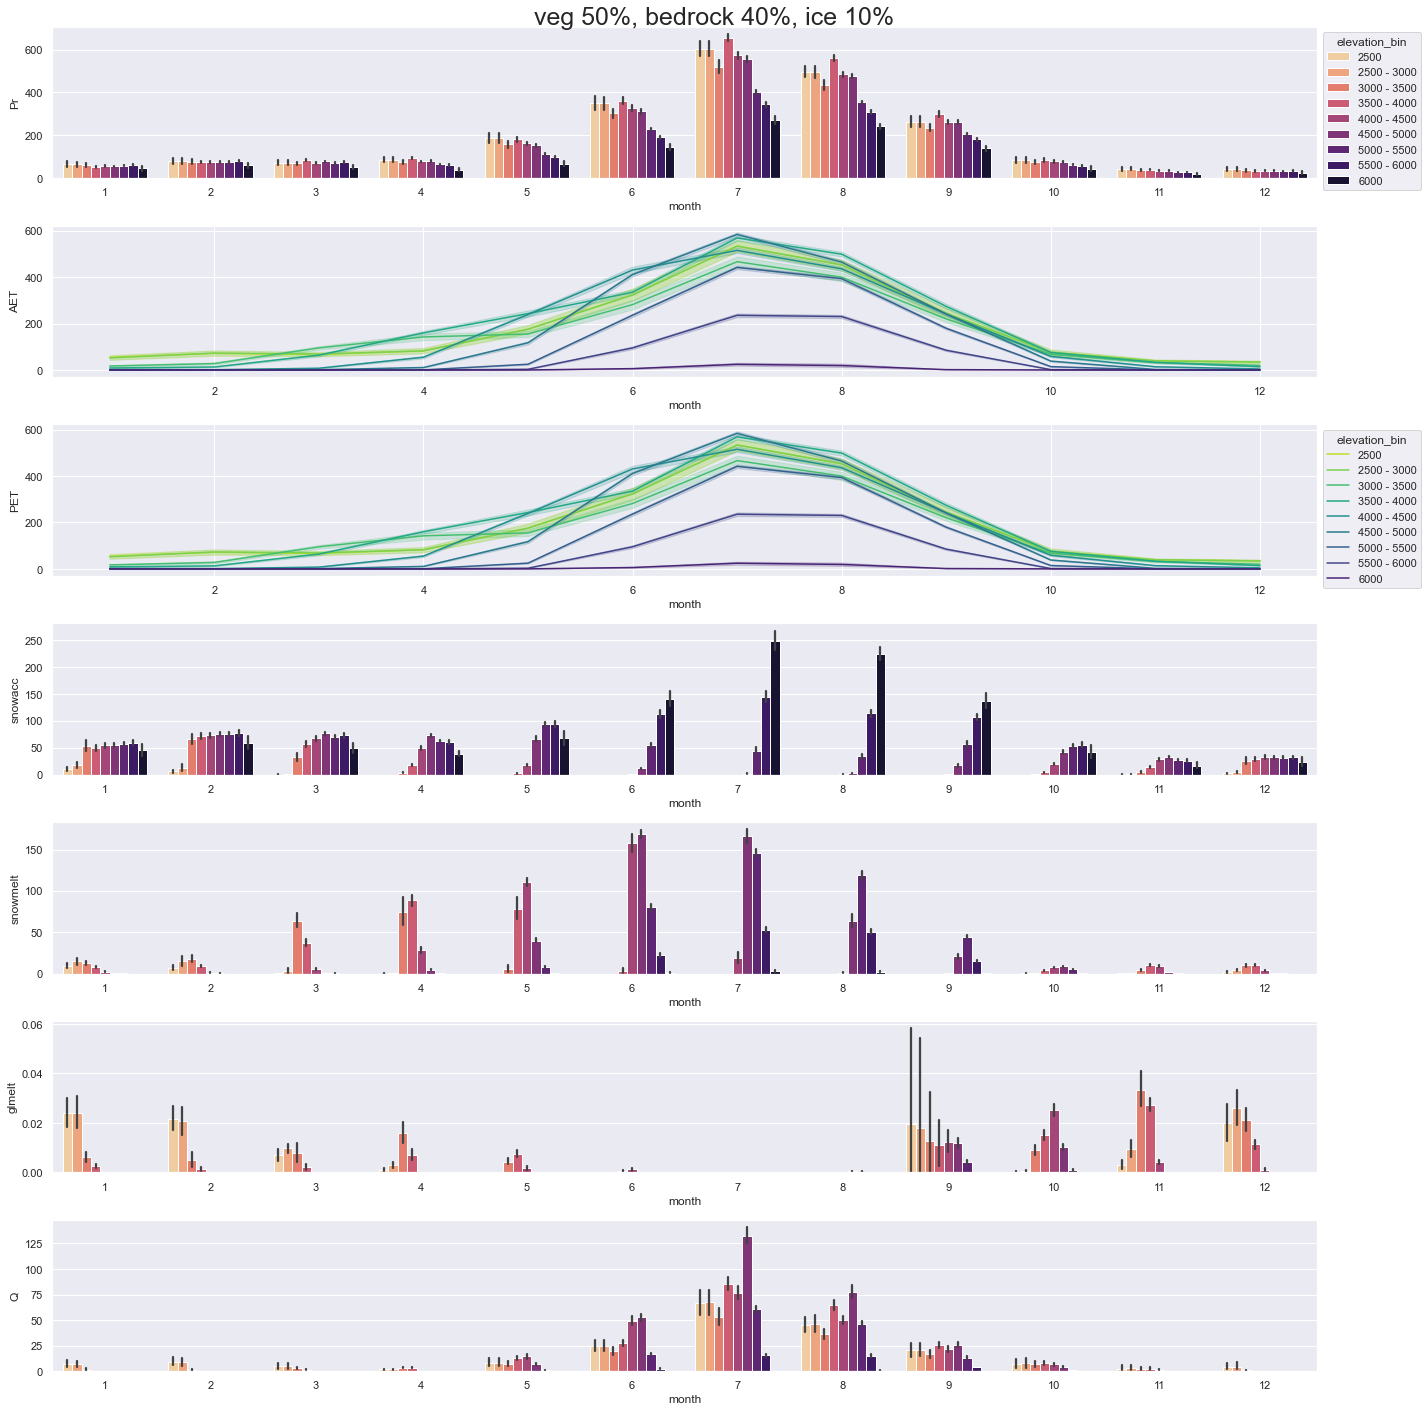

In [103]:
fig = plt.figure(figsize=(20, 20), layout = 'tight')
mosaic = fig.subplot_mosaic('''
                            aaa
                            bbb
                            ccc
                            ddd
                            eee
                            fff
                            ggg
                            ''')


sns.barplot(ax = mosaic['a'], x='month', y='Pr', hue = 'elevation_bin', data=pr1_melted, palette = 'magma_r', legend = True) 
sns.lineplot(ax = mosaic['b'], x='month', y='AET', hue = 'elevation_bin', data=aet1_melted, palette = 'viridis_r', legend = False) 
sns.lineplot(ax = mosaic['c'], x='month', y='PET', hue = 'elevation_bin', data=pet1_melted, palette = 'viridis_r', legend = True)
sns.barplot(ax = mosaic['d'], x='month', y='snowacc', hue = 'elevation_bin', data=snowacc1_melted, palette = 'magma_r', legend = False)
sns.barplot(ax = mosaic['e'], x='month', y='snowmelt', hue = 'elevation_bin', data=snowmelt1_melted, palette = 'magma_r', legend = False)
sns.barplot(ax = mosaic['f'], x='month', y='glmelt', hue = 'elevation_bin', data=glmelt1_melted, palette = 'magma_r', legend = False)
sns.barplot(ax = mosaic['g'], x='month', y='Q', hue = 'elevation_bin', data=Q1_melted, palette = 'magma_r', legend = False)


sns.move_legend(mosaic['a'], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(mosaic['c'], "upper left", bbox_to_anchor=(1, 1))

# # Adding text to the top-left corner of each subplot
# mosaic['a'].text(0.02, 0.95, 'veg 40%, bedrock 40%, ice 20%', transform=mosaic['a'].transAxes, fontsize=25, verticalalignment='top')
# mosaic['b'].text(0.02, 0.95, 'veg 40%, bedrock 50%, ice 10%', transform=mosaic['b'].transAxes, fontsize=25, verticalalignment='top')
# mosaic['c'].text(0.02, 0.95, 'veg 50%, bedrock 40%, ice 10%', transform=mosaic['c'].transAxes, fontsize=25, verticalalignment='top')
# mosaic['d'].text(0.02, 0.95, 'veg 40%, bedrock 60%, ice 0%',  transform=mosaic['d'].transAxes, fontsize=25, verticalalignment='top')





if landcover_idx ==1:
    plt.suptitle('veg 40%, bedrock 40%, ice 20%', fontsize = 25)
if landcover_idx ==2:
    plt.suptitle('veg 40%, bedrock 50%, ice 10%', fontsize = 25)
if landcover_idx ==3:
    plt.suptitle('veg 50%, bedrock 40%, ice 10%', fontsize = 25)

# plt.savefig('water_balance_components_landcover3.png', dpi = 300, bbox_inches = 'tight')